# First some probability measures

In [40]:
import numpy as np
from matplotlib import pylab as plt
import scipy.spatial.distance as dist
from scipy import special as spc
plt.rcParams['figure.figsize'] = 12, 8

In [41]:
# basic parameters
N = 1000
D = 100
# LSH parameters
r = 2.5

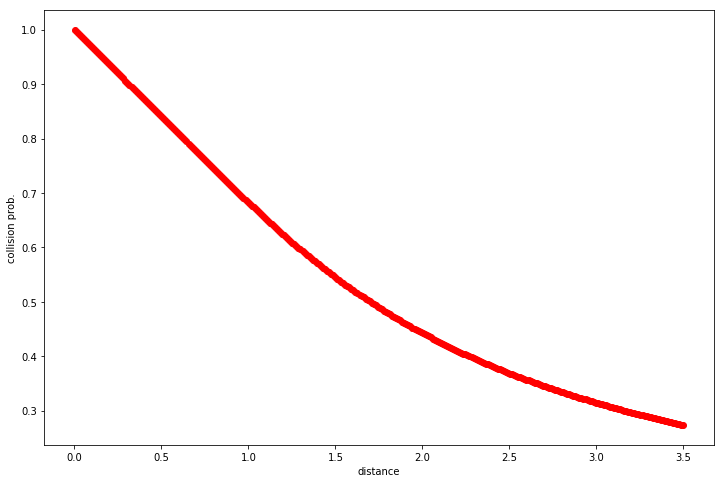

In [42]:
def pc(c, r):
    return spc.erf(r / (np.sqrt(2) * c)) - \
        np.sqrt(2/np.pi) * (c/r) * (1 - np.exp(-.5 * (r/c)**2))
x = np.linspace(.0001, (r + 1), 300)
y = map(lambda x: pc(x, r), x)
plt.plot(x, y, 'ro');
plt.xlabel('distance'); plt.ylabel('collision prob.')
plt.show()

In [43]:
r1 = 3.3
r2 = 4.0
K_MIN, K_MAX = (2, 10)
L_MIN, L_MAX = (3, 100)

div_min = float('inf')
for i in range(K_MIN, K_MAX):
    for l in range(L_MIN, L_MAX):
        p1 = 1. - (1. - pc(r1, r)**i)**l
        p2 = 1. - (1. - pc(r2, r)**i)**l
        f = np.log(1./p1) / np.log(1./p2)
        if f < div_min:
            div_min = f
            k_min = i
            l_min = l
print 'k_min:',k_min,'l_min:',l_min
print 'p2/p1:',(p2/p1)
print 'p1:',p1,'p2:',p2

L = l_min
k = k_min
n_hash = k * L

k_min: 2 l_min: 99
p2/p1: 0.201737051707
p1: 0.00137249069096 p2: 0.00027688222549


In [44]:
L = 10
k = 7
n_hash = k * L
p1 = 1. - (1. - pc(r1, r)**k)**L
p2 = 1. - (1. - pc(r2, r)**k)**L

print 'p1:',p1,'p2:',p2

p1: 0.00166479873295 p2: 0.000479388988158


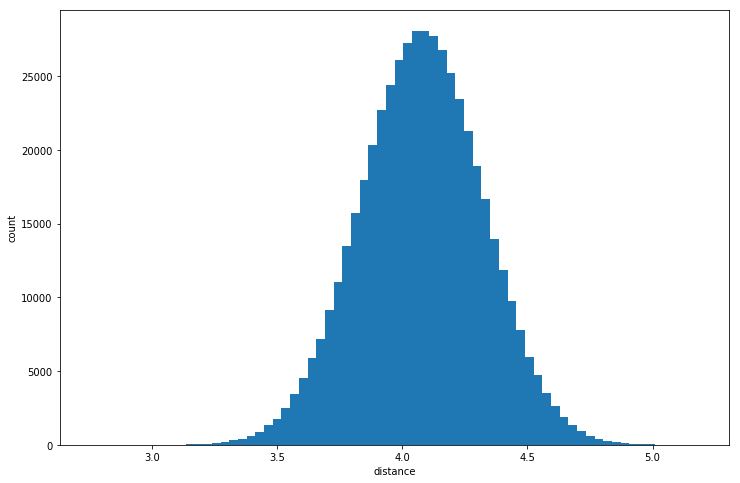

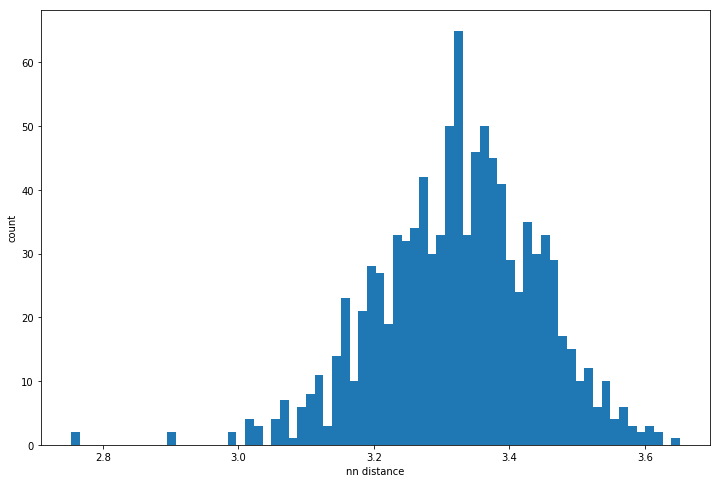

In [46]:
# data generation
data = np.random.rand(N, D)
pw_data = dist.pdist(data, metric='euclidean')
pw_data_matrix = dist.squareform(pw_data)
pw_data_sorted = np.argsort(pw_data_matrix, axis=1)
dists_nn = pw_data_matrix[range(N), pw_data_sorted[:,1]]

plt.hist(pw_data, 70); 
plt.xlabel('distance'); plt.ylabel('count')
plt.show()

plt.clf()
plt.hist(dists_nn, 70)
plt.xlabel('nn distance'); plt.ylabel('count')
plt.show()

In [47]:
# hash
hashed = np.random.random(size=(n_hash, D))
hashed = np.dot(data, hashed.T)
b = r * np.random.random(n_hash)
hashed = np.floor((hashed + b) / r)
print 'hashed.shape:',hashed.shape
print '(N,L,k):',(N,L,k)
hashed = hashed.reshape((N, L, k))
hashed = hashed.astype(dtype=np.int8)
print 'hashed.shape:',hashed.shape

hashed.shape: (1000, 70)
(N,L,k): (1000, 10, 7)
hashed.shape: (1000, 10, 7)


In [48]:
# fill buckets
buckets = {}
for i in range(N):
    for l in range(L):
        key = tuple(hashed[i, l])
        if not key in buckets:
            buckets[key] = set([i])
        else:
            buckets[key].add(i)
# print 'buckets:',buckets
buckets_len = []
for key in buckets:
    buckets_len.append(len(buckets[key]))
buckets_len = sorted(buckets_len, reverse=True)
print 'n buckets:',len(buckets_len)
print 'buckets_len[:50]:',buckets_len[:50]

n buckets: 2380
buckets_len[:50]: [74, 67, 64, 56, 55, 53, 53, 52, 51, 47, 45, 44, 44, 43, 42, 42, 41, 39, 39, 38, 38, 38, 37, 36, 36, 35, 35, 35, 34, 34, 34, 33, 33, 33, 33, 33, 32, 32, 32, 31, 31, 31, 30, 30, 30, 29, 29, 29, 28, 28]


perc: 0.124124
TEST: False


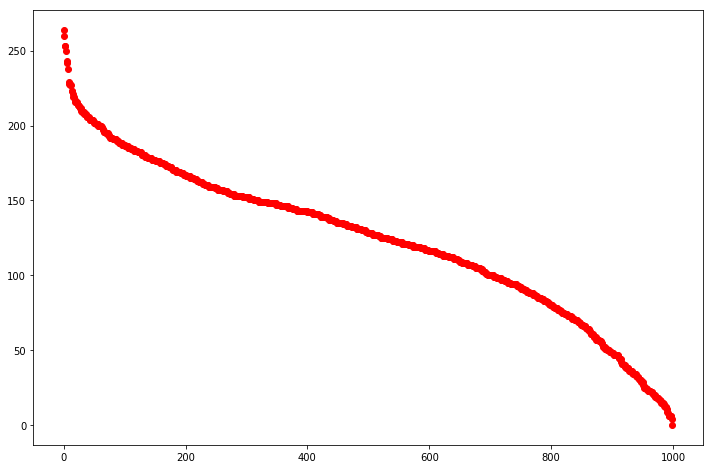

In [49]:
# cumulate potential nearest neighbors
nn_idx = []
for i in range(N):
    nn_idx.append(set([]))
    for l in range(L):
        key = tuple(hashed[i, l])
        nn_idx[i] = nn_idx[i].union(buckets[key])
    nn_idx[i].remove(i)
nn_lengths = map(lambda x: len(x), nn_idx)
nn_lengths.sort(reverse=True)
# print 'nn_idx:',nn_idx
comp_total = 0
for i in range(N):
    comp_total += len(nn_idx[i])
comp_naive = N**2
perc = float(comp_total) / comp_naive
print 'perc:',perc
print 'TEST:',(6 in nn_idx[6])

plt.plot(nn_lengths, 'ro');
plt.show()

In [50]:
idx = 2
print 'nn:',pw_data_sorted[idx,1]
print 'len(nn_idx):',len(nn_idx[idx])
nn_present = pw_data_sorted[idx,1] in nn_idx[idx]
print 'nn_present:',nn_present
n_correct = 0
for i in range(N):
    if pw_data_sorted[i,1] in nn_idx[i]:
        n_correct += 1
print 'perc correct:',(float(n_correct)/N)

nn: 804
len(nn_idx): 109
nn_present: True
perc correct: 0.228


empty buckets: 1


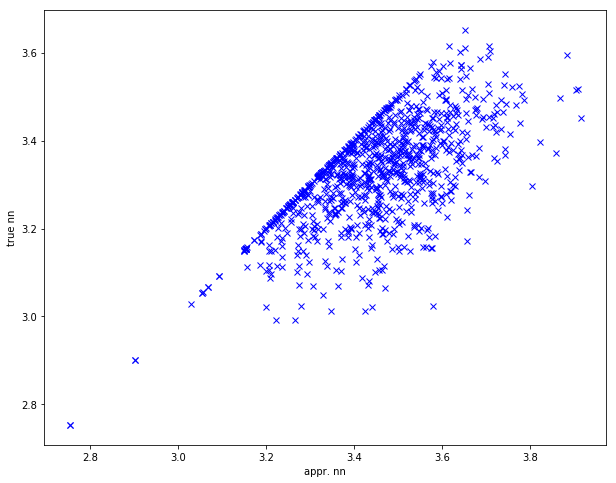

In [51]:
# find approximate nn
ann = []
true_nn = []
empty_buckets = 0
for i in range(N):
    if len(nn_idx[i]) == 0:
        empty_buckets += 1
    else:
        nn_dist = np.min(pw_data_matrix[i, np.array(list(nn_idx[i]))])
        ann.append(nn_dist)
        true_nn.append(dists_nn[i])
ann = np.array(ann)
true_nn = np.array(true_nn)
print 'empty buckets:',empty_buckets

plt.plot(ann, true_nn, 'bx');
plt.xlabel('appr. nn');
plt.ylabel('true nn');
plt.axes().set_aspect('equal')
plt.show()

# Maximum inner product search using Asymmetric Locality Sensitive Hashing

## For small Dataset

In [1]:
import os
import pandas as pd
import numpy as np

dataset = "datasets"+os.path.sep+"ml-latest-small"
#dataset = "datasets"+os.path.sep+"ml-latest"
name = "ratings.csv"
ratings_df = pd.read_csv(dataset + os.path.sep + name, names= ["UserID", "MovieID", "Rating", "Timestamp"], header=0)
ratings_df["UserID"] = pd.to_numeric(ratings_df["UserID"], errors='ignore')
ratings_df["MovieID"] = pd.to_numeric(ratings_df["MovieID"], errors='ignore')
ratings_df["Rating"] = pd.to_numeric(ratings_df["Rating"], errors='ignore')
ratings_df["Timestamp"] = pd.to_numeric(ratings_df["Timestamp"], errors='ignore')
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)

R = R_df.as_matrix()
#user_ratings_mean = np.mean(R, axis = 1)
#R_demeaned = R - user_ratings_mean.reshape(-1, 1)


Executed on a smaller dataset at present


## Netflix Dataset

In [2]:
# import pandas as pd
# import numpy as np


# users = []
# movies_=[]
# for p_ in range(0, 17770):
#     movies_.append(p_)
    
    

# values = np.zeros((480189, 17770), dtype='float32')
# df = pd.DataFrame(data=values)

# for x in range(0, 17770):
#     name = "%07d" % (x+1,)
#     name = (str)(name)
#     name = "training_set/mv_"+name+".txt"
#     f = open(name, "r")
#     p = f.read()
#     lines = p.split('\n')
#     movie_=lines.pop(0)
#     movie_=(int)(movie_[0:-1])
#     if (movie_==x+1):
#         print(x+1)
#     for l in lines:
#         if (l != ''):
#             line1=l.split(',')
#             print(line1[0])
#             if (int)(line1[0]) not in users:
#                 users.append((int)(line1[0]))
        
#             df[x][users.index((int)(line1[0]))] = (float)(line1[1])
#     f.close()

    

    
# R_df = df.pivot(index = users, columns = movies_).fillna(0)
# R = R_df.as_matrix()
# user_ratings_mean = np.mean(R, axis = 1)
# R_demeaned = R - user_ratings_mean.reshape(-1, 1)
# from scipy import io
# io.mmwrite("Ratings_ML", R_demeaned, field='real', precision=4)


## Movielens Dataset

In [3]:
# import os
# import numpy as np
# import pandas as pd
# from scipy import sparse

# ratings_df = pd.read_csv("ratings.dat",sep="::", names= ["UserID", "MovieID", "Rating", "Timestamp"], header=0)
# ratings_df["UserID"] = pd.to_numeric(ratings_df["UserID"], errors='ignore')
# ratings_df["MovieID"] = pd.to_numeric(ratings_df["MovieID"], errors='ignore')
# ratings_df["Rating"] = pd.to_numeric(ratings_df["Rating"], errors='ignore')
# ratings_df["Timestamp"] = pd.to_numeric(ratings_df["Timestamp"], errors='ignore')
# R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
# R = R_df.as_matrix()
# #user_ratings_mean = np.mean(R, axis = 1)
# #R_demeaned = R - user_ratings_mean.reshape(-1, 1)
# #from scipy import io
# #io.mmwrite("Ratings_ML", R_demeaned, field='real', precision=4)


# Test Train split



## 20% of the ratings are converted to zeroes in train data
## That 20% is our train data


###Implement cross-validation

In [4]:
from scipy import sparse

#sR = sparse.csc_matrix(R)
TRAIN_SIZE = 0.90
# Create boolean mask
# np.random creates a vector of random values between 0 and 1
# Those values are filtered to create a binary mask
msk = np.random.rand(R.shape[0],R.shape[1]) < TRAIN_SIZE
r = np.zeros(R.shape)
print (msk.shape)
 
train_ratings = R.copy()
test_ratings = R.copy()
#mask itself is random
train_ratings[msk] = r[msk]
test_ratings[~msk] = r[~msk] # inverse of boolean mask

(671, 9066)


In [5]:
print(np.shape(train_ratings))
print(np.shape(test_ratings))

(671, 9066)
(671, 9066)


In [6]:
K = 128
train_r = sparse.csc_matrix(train_ratings)
test_r = sparse.csc_matrix(test_ratings)
from sparsesvd import sparsesvd
Ut, sigma, Vt = sparsesvd(train_r, K)
sigma = np.diag(sigma)
U = Ut.transpose()
U = U.dot(sigma)
Ut2, sigma2, Vt2 = sparsesvd(test_r, K)
sigma2 = np.diag(sigma2)
U2 = Ut2.transpose()
U2 = U2.dot(sigma)

In [7]:
np.save('query.npy', Vt2)
np.save('dataset.npy', U)

In [8]:
np.shape(Vt2)

(128, 9066)

# Preprocessing if done once, it need not be done again

In [9]:
# movielens data
import numpy as np
queries = np.load('query.npy')
data = np.load('dataset.npy')

In [10]:
D = 128
U = 0.83
M = 3

# scale data
data_norms = np.linalg.norm(data, axis=1)
data_max_norm = np.max(data_norms)
data /= (data_max_norm / U)
print("ok")
# normalize queries
queries_norms = np.linalg.norm(queries, axis=1)
queries_normed = (queries.T / queries_norms).T
queries = queries_normed
print("okok")

ok
okok


In [11]:
queries = queries.transpose()

In [12]:
print(np.shape(queries))
print(np.shape(data))

(9066, 128)
(671, 128)


In [13]:
from matplotlib import pylab as plt
from collections import Counter
import utils
plt.rcParams['figure.figsize'] = 10, 7

(6083286,)
(9066, 671)
(9066, 671)
done1
(9066, 671)
(9066, 671)
(6083286,)
done2
done3


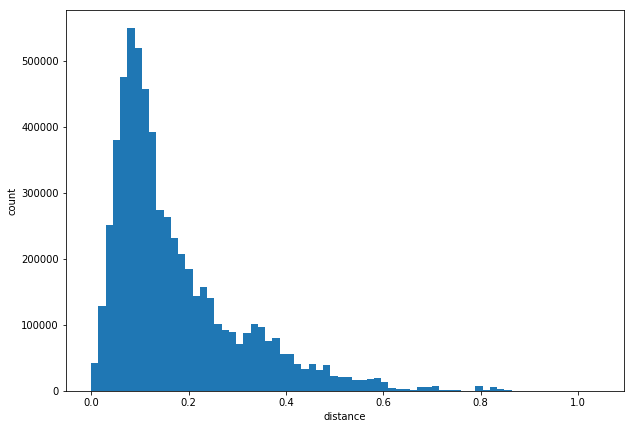

done4


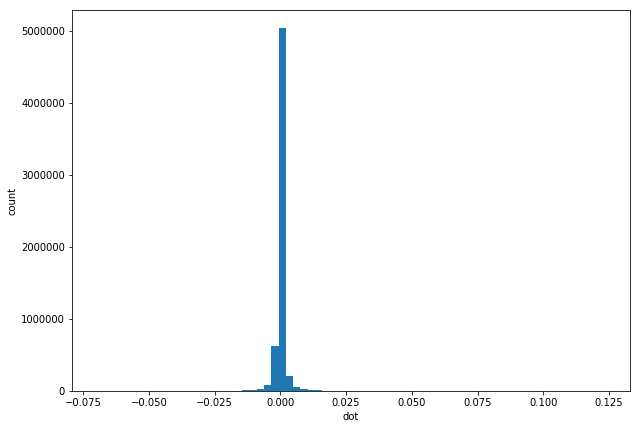

In [14]:
# pairwise euclidean distances
euclidean_matixPts, euclidean_argsPts, euclidean_Pts = utils.distances(queries, data)
print(np.shape(euclidean_Pts))
print(np.shape(euclidean_argsPts))
print(np.shape(euclidean_matixPts))
print("done1")
# pairwise scalar products
pw_dot, dot_argsPts, pw_dot_1D = utils.dot_prod(queries, data)
print(np.shape(pw_dot))
print(np.shape(dot_argsPts))
print(np.shape(pw_dot_1D))
print("done2")
plt.hist(euclidean_Pts, 70); 
print("done3")
plt.xlabel('distance'); plt.ylabel('count');
plt.show()
plt.hist(pw_dot_1D, 70); 
print("done4")
plt.xlabel('dot'); plt.ylabel('count');
plt.show()

In [15]:
L2LSH
import utils
N=128
t = T
hash_L2LSH = utils.hashedFunctions(N_HASH, D)
r_list = np.array([1., 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
perf_min = np.float('inf')
r_min = 2.5#-1.
for r in r_list:
    print 'r:',r
    hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
    hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
    pw_hashed_L2LSH, pw_hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
    perf = 0.0
    for k in range(N):
        top_t_inds = utils.topTindices(pw_hashed_args_L2LSH[k], pw_dot_args[k], t)
        if k < 10:
            print 'top:',top_t_inds
        perf += np.mean(top_t_inds)
    perf /= N
    if perf < perf_min:
        perf_min = perf
        r_min = r
    print 'perf:',perf
print 'r_min:',r_min
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r_min)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r_min)
pw_hashed_L2LSH, pw_hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)

In [16]:
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(N_HASH, (D + M))
r_list = np.array([1., 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
perf_min = np.float('inf')
r_min = -1.
for r in r_list:
    print 'r:',r
    hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
    hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
    pw_hashed_ALSH, pw_hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
    perf = 0.0
    for k in range(N):
        top_t_inds = utils.topTindices(pw_hashed_args_ALSH[k], pw_dot_args[k], t)
        perf += np.mean(top_t_inds)
        if k < 10:
            print 'top:',top_t_inds
    perf /= N
    if perf < perf_min:
        perf_min = perf
        r_min = r
    print 'perf:',perf
print 'r_min:',r_min
r_min = 2.5
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r_min)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r_min)
pw_hashed_ALSH, pw_hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)

# T = 10

prec L2LSH...
prec ALSH...


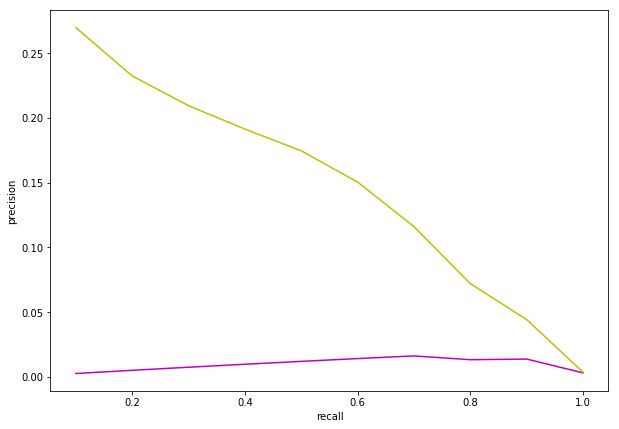

In [28]:
T = 10
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(512, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(512, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

# In the above graph, magenta is L2LSH, yellow is ALSH

# T = 5

In [22]:
T = 5
r = 2.5

In [23]:
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(256, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)

In [24]:
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(256, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)

prec L2LSH...
prec ALSH...


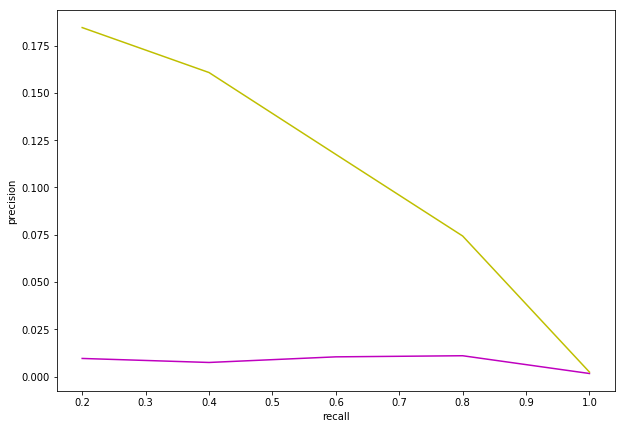

In [25]:
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

prec L2LSH...
prec ALSH...


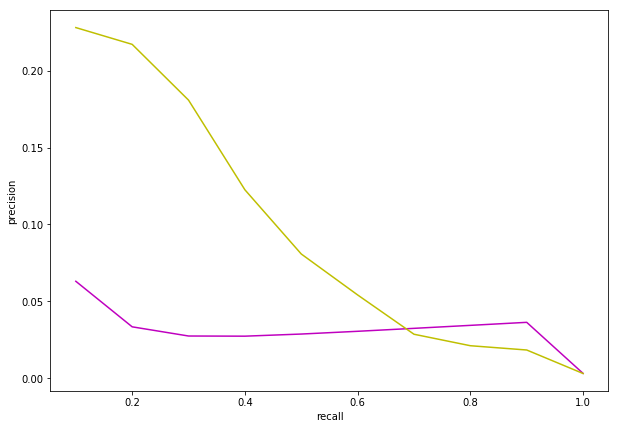

In [27]:
T = 10
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(128, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(128, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

prec L2LSH...
prec ALSH...


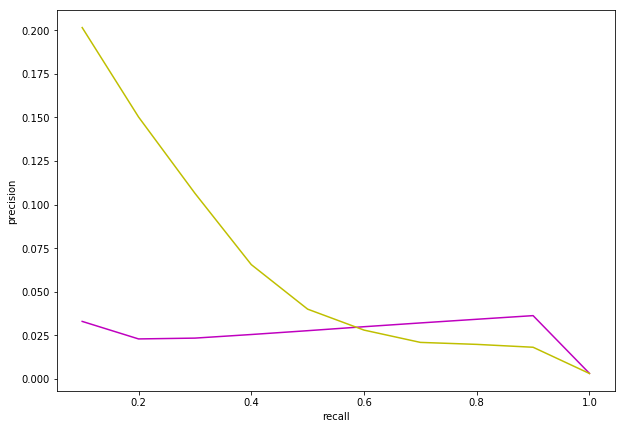

In [29]:
T = 10
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(64, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(64, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

prec L2LSH...
prec ALSH...


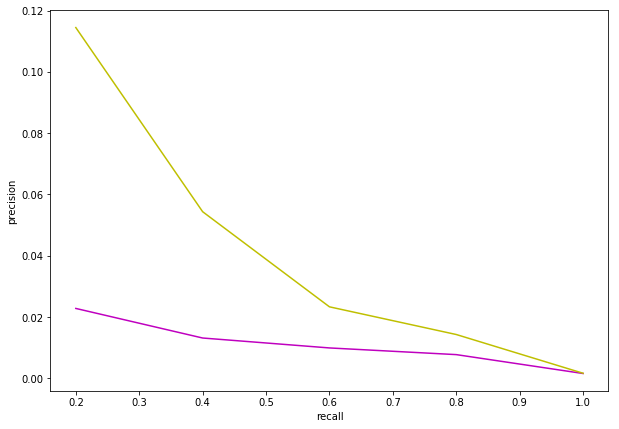

In [32]:
T = 5
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(512, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(512, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

prec L2LSH...
prec ALSH...


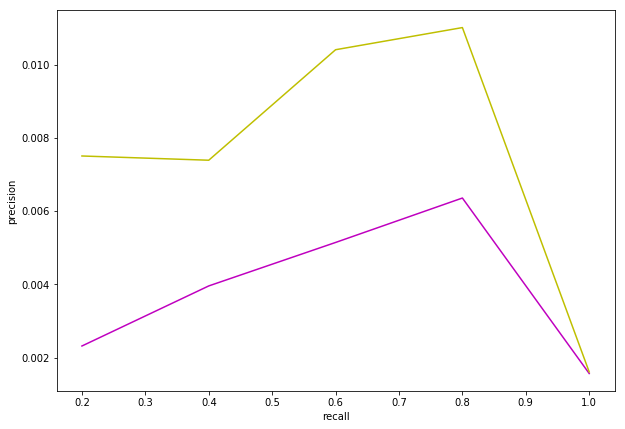

In [33]:
T = 5
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(256, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(256, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

prec L2LSH...
prec ALSH...


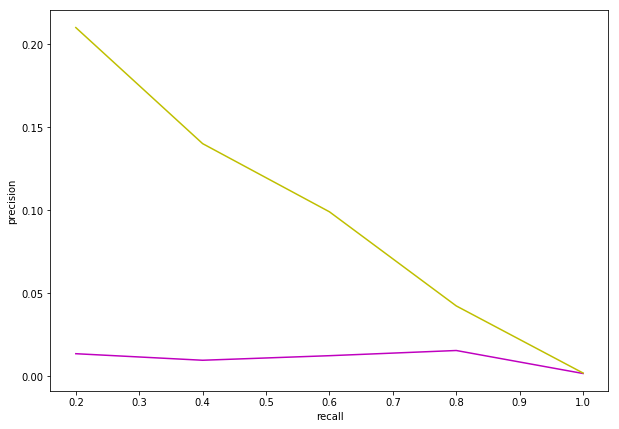

In [35]:
T = 5
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(128, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(128, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()

prec L2LSH...
prec ALSH...


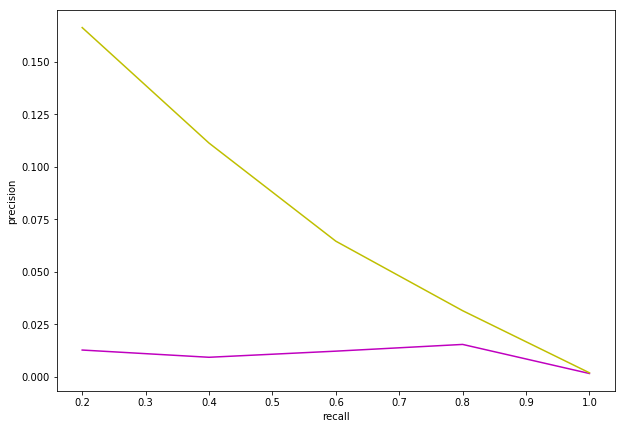

In [36]:
T = 5
r = 2.5
#L2LSH
t = T
hash_L2LSH = utils.hashedFunctions(64, D)
hashed_data_L2LSH = utils.dataToHashFunctions(data, hash_L2LSH, r)
hashed_queries_L2LSH = utils.dataToHashFunctions(queries, hash_L2LSH, r)
hashed_L2LSHPts, hashed_args_L2LSH = utils.hammDist(hashed_queries_L2LSH, hashed_data_L2LSH)
# ALSH
data_trans, queries_trans = utils.ALSHDataTransform(data, queries, M)
t = T
hash_ALSH = utils.hashedFunctions(64, (D + M))
hashed_data_ALSH = utils.dataToHashFunctions(data_trans, hash_ALSH, r)
hashed_queries_ALSH = utils.dataToHashFunctions(queries_trans, hash_ALSH, r)
hashed_ALSHPts, hashed_args_ALSH = utils.hammDist(hashed_queries_ALSH, hashed_data_ALSH)
recall = np.linspace(1./T, 1, T)
print 'prec L2LSH...'
prec_L2LSH = utils.precisionRecall(hashed_args_L2LSH, dot_argsPts, T)
print 'prec ALSH...'
prec_ALSH = utils.precisionRecall(hashed_args_ALSH, dot_argsPts, T)
plt.xlabel('recall'); plt.ylabel('precision');
plt.plot(recall, prec_L2LSH, 'm' ,label='L2LSH');
plt.plot(recall, prec_ALSH,'y', label='ALSH');
plt.show()